# Importing libraries

In [ ]:
!pip install -U accelerate
!pip install -U transformers
!pip install transformers[torch]
!pip install accelerate -U
!pip install rouge_score
!pip install evaluate
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from transformers import AutoTokenizer
import evaluate
import torch
from PIL import Image
import matplotlib.pyplot as plt

## Importing text data

In [ ]:
text_data = pd.read_csv('/kaggle/input/captionsuuuiiii/captions.txt', sep='|')
text_data

# Data preparation

In [ ]:
text_data.rename(columns={"comment_number":"image_repeat","comment":"caption"},inplace=True)

In [ ]:
text_data_train = text_data.drop(text_data[text_data['image_repeat']==0].index)
text_data_train.reset_index(drop=True, inplace=True)

text_data_val = text_data[ text_data['image_repeat']==0 ]
text_data_val.reset_index(drop=True, inplace=True)

text_data_train.shape, text_data_val.shape

# Vision Encoder Decoder Models

In [5]:
batch_size = 52
epochs = 1

In [6]:
from transformers import AutoImageProcessor, AutoTokenizer, VisionEncoderDecoderModel
from PIL import Image
import requests

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
decoder_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", add_special_tokens=True)

if decoder_tokenizer.pad_token is None:
    decoder_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224-in21k", "bert-base-uncased")

# ids
model.config.decoder_start_token_id = decoder_tokenizer.cls_token_id
model.config.pad_token_id = decoder_tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

In [7]:
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
# from datasets import Dataset
image_height = 224
image_width = 224

class ImageCaptionDataset(Dataset):
    def __init__(self, image_path, text_df, tokenizer, image_height,image_width,image_processor ):
        self.image_path = image_path
        self.text_df = text_df
        self.tokenizer = tokenizer
        self.image_height = image_height
        self.image_width = image_width
        self.image_processor=image_processor 
    def __len__(self):
        return self.text_df.shape[0]
    
    def __getitem__(self, index):
        path_filename = self.image_path + text_data_train.iloc[index]['image_name']
        image = Image.open(path_filename).convert('RGB')
        image = self.image_processor(images=[image], return_tensors='pt').pixel_values
        caption = str(text_data_train.iloc[index]['caption'])  # Convert the caption to a string
        caption_token = self.tokenizer(caption, add_special_tokens=True, padding="max_length", max_length=32, truncation=True).input_ids
        caption_token = [token if token != self.tokenizer.pad_token_id else -100 for token in caption_token]
        return {"pixel_values": image.squeeze(), "caption_token": torch.tensor(caption_token)}
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    caption_tokens = [item["caption_token"] for item in batch]
    
    pixel_values = pad_sequence(pixel_values, batch_first=True)
    caption_tokens = pad_sequence(caption_tokens, batch_first=True, padding_value=-100)
    
    return {"pixel_values": pixel_values, "caption_token": caption_tokens}

train_dataset = ImageCaptionDataset( image_path="/kaggle/input/imagesuiiiii/Images - Copy/", text_df=text_data_train , tokenizer=decoder_tokenizer, image_height=224, image_width=224,image_processor=image_processor )
val_dataset = ImageCaptionDataset( image_path="/kaggle/input/imagesuiiiii/Images - Copy/", text_df=text_data_val , tokenizer=decoder_tokenizer, image_height=224, image_width=224,image_processor=image_processor  )

# Display few images

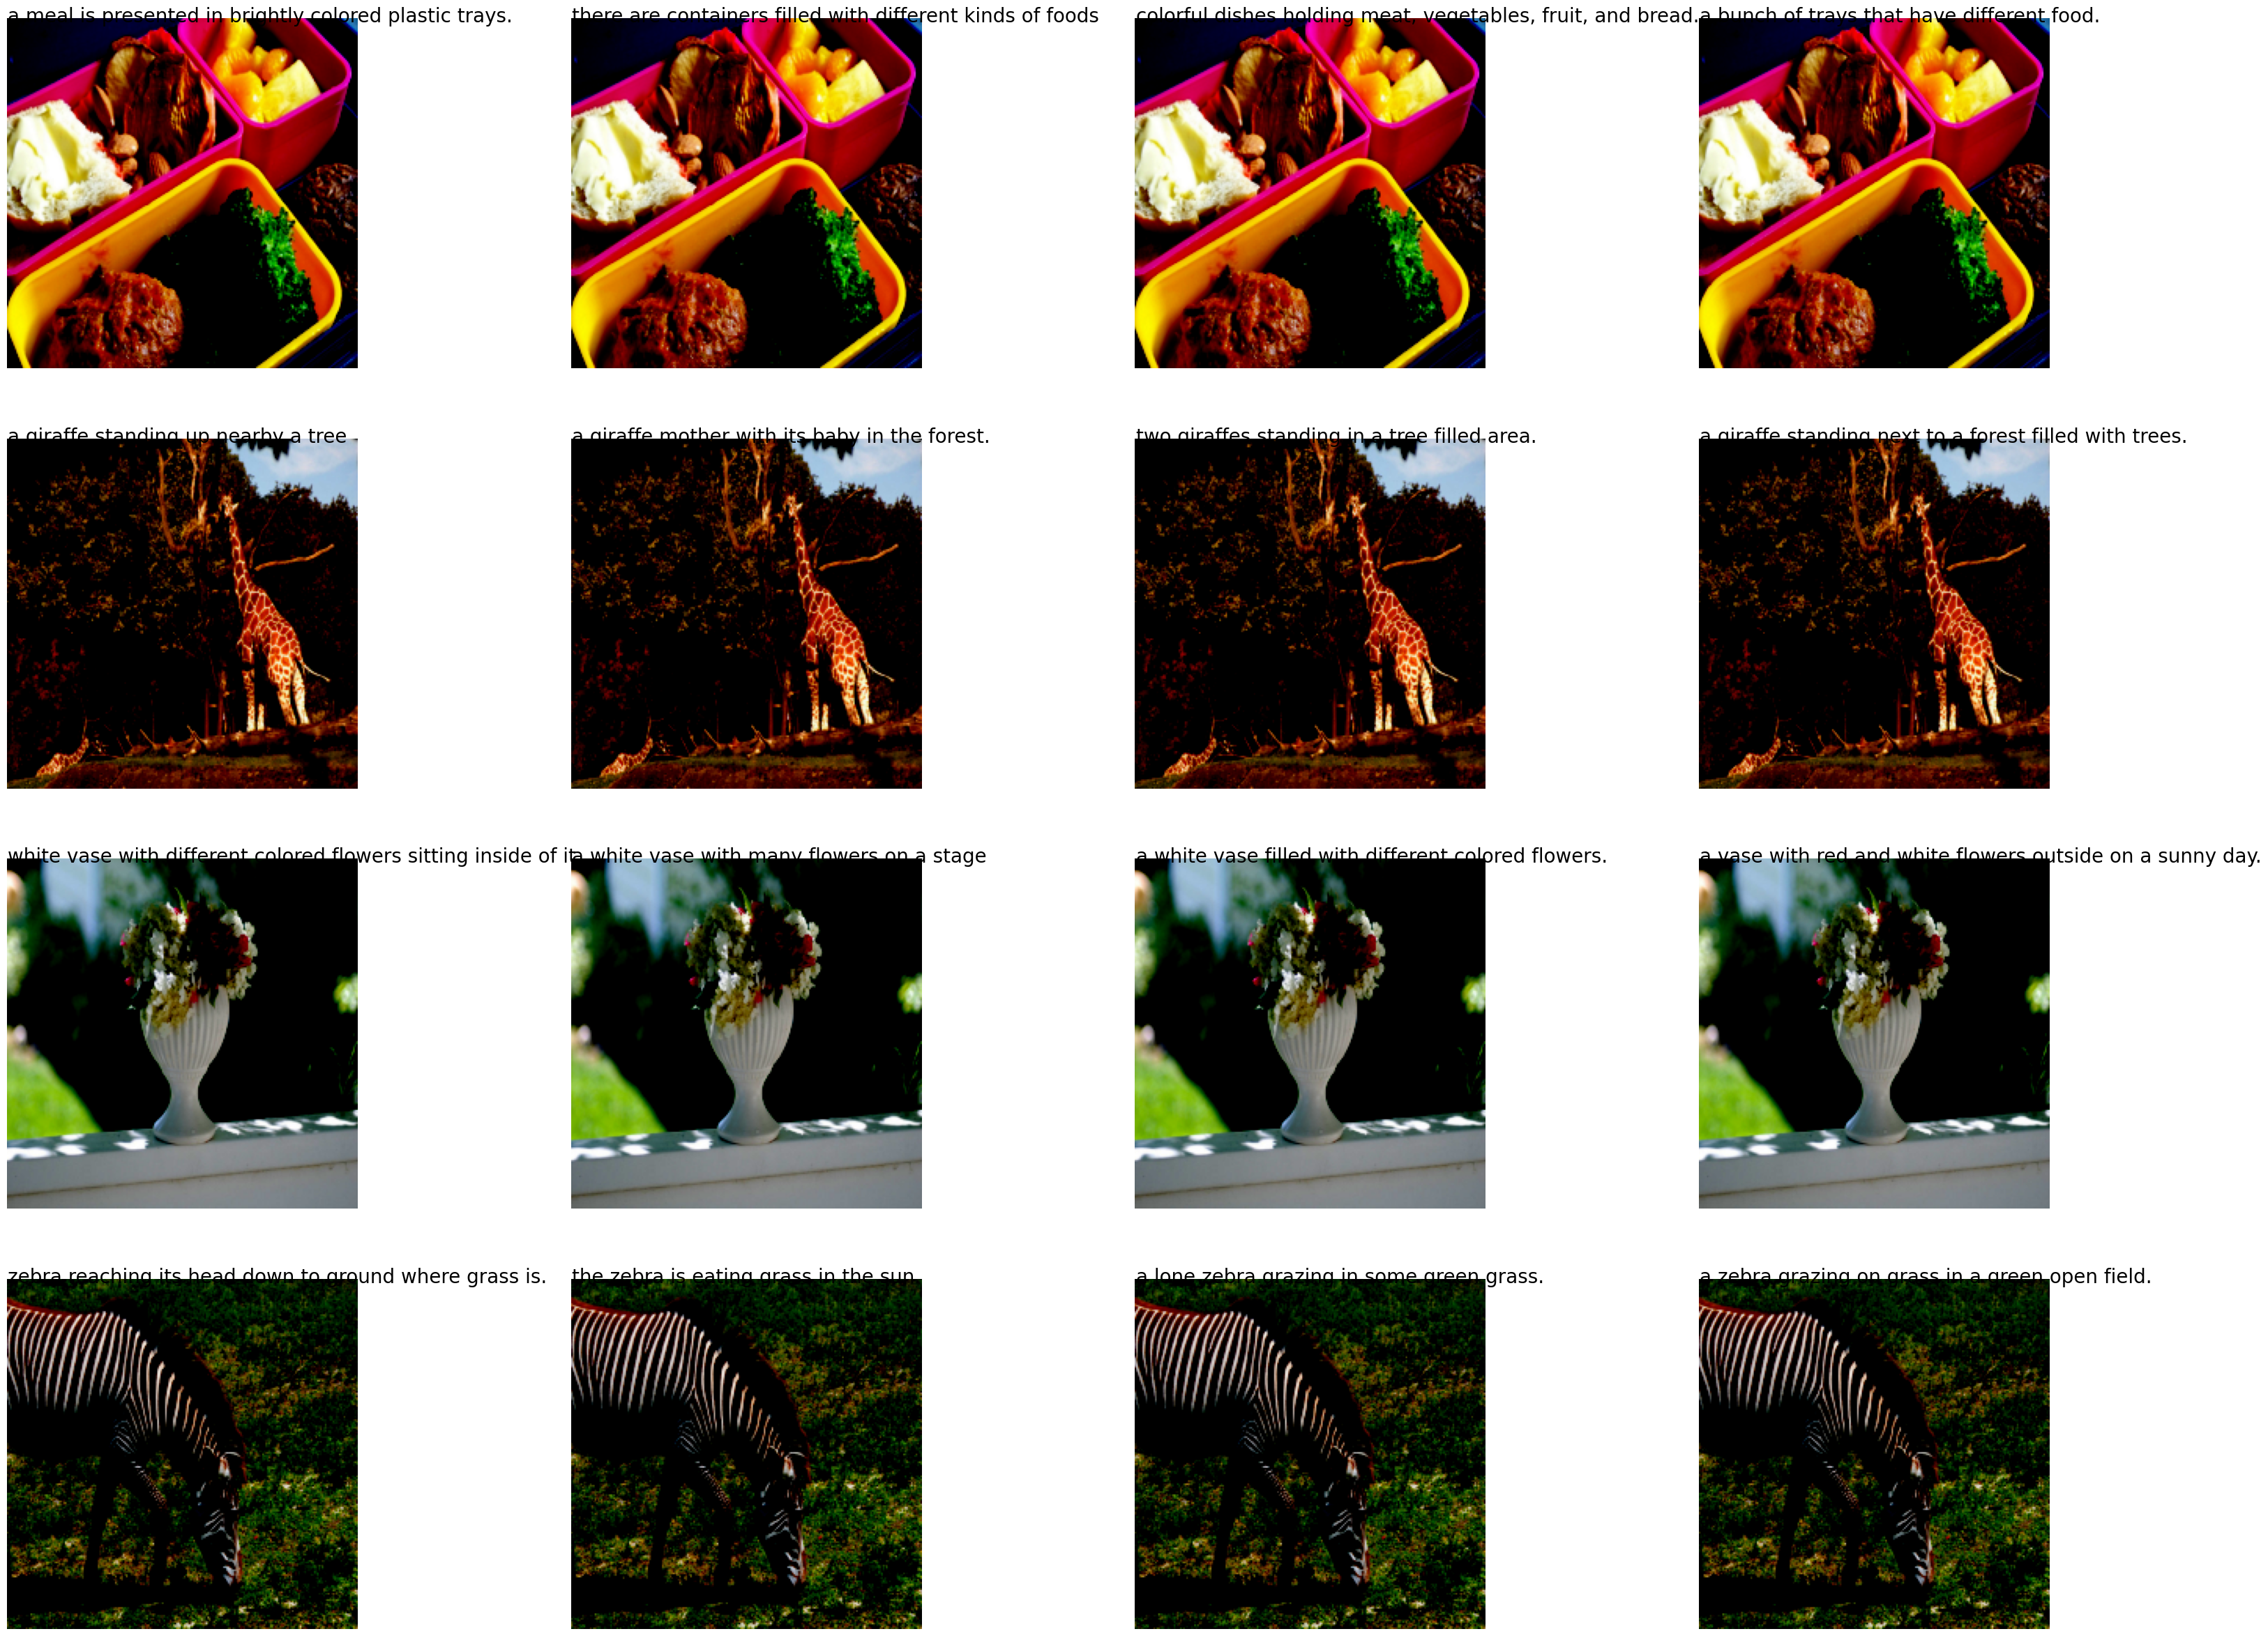

In [8]:
# Display fews images
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(np.moveaxis(train_dataset.__getitem__(i)['pixel_values'].numpy(), 0, -1))
    plt.axis('off')
    # caption (small font size)
    caption = []
    for word in decoder_tokenizer.decode( [0 if token==-100 else token for token in train_dataset.__getitem__(i)['caption_token'].numpy()] ).split():
        if word not in decoder_tokenizer.all_special_tokens:
            caption.append(word)
    caption = " ".join(caption)
    plt.text(0, 2, caption, fontsize=20)
    # largen plot size
    plt.gcf().set_size_inches(40, 30)
    
plt.show()

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Training Setup

In [10]:
from transformers import VisionEncoderDecoderModel

# Load the model
model = VisionEncoderDecoderModel.from_pretrained("/kaggle/input/model50-pt")

In [11]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

from transformers import get_scheduler
num_training_steps = epochs * len(train_dataloader)
lr_scheduler = get_scheduler( name="linear", optimizer=optimizer, num_warmup_steps=int(num_training_steps/5), num_training_steps=num_training_steps )


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
model.to(device)
print(device)
# Set GPU/CPU

cuda


# Training model

In [12]:
torch.cuda.empty_cache()

In [ ]:
from tqdm.auto import tqdm
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(epochs):
    losses = []
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(pixel_values = batch['pixel_values'], labels=batch['caption_token']) # decoder_input_ids=batch['caption_token'],
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        losses.append(loss)
        
        torch.cuda.empty_cache()
        
    if epoch in [2,4,6,8,10]: 
        model.save_pretrained(f"Save_at_{epoch}_epochs.pt")
        print(loss)
        print(f'Saved at {epoch}')
        
    print('Epoch: {}, Loss: {}'.format(epoch, sum(losses)))

  0%|          | 0/11929 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


# Saving model

In [ ]:
# Saving the model, including its configuration
model.save_pretrained("model51.pt")

# Generating captions

In [ ]:
def generate_caption(image, model, tokenizer, device):
    # Convert image to tensor and move it to the appropriate device
    image = torch.unsqueeze(torch.tensor(image), 0).to(device)
    
    # Encode image using the model's encoder
    encoder_output = model.encoder(pixel_values=image)
    
    # Initialize the decoder input with the special token for start of sequence
    decoder_input_ids = torch.tensor(tokenizer.encode("[CLS]")).unsqueeze(0).to(device)
    
    # Initialize the list to hold generated token IDs
    generated_ids = []
    
    # Set maximum length for generated caption
    max_length = 32
    
    # Generate tokens one by one using the decoder
    for _ in range(max_length):
        # Generate next token
        outputs = model.decoder(input_ids=decoder_input_ids, encoder_hidden_states=encoder_output.last_hidden_state)
        next_token_logits = outputs.logits[:, -1, :]
        next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
        
        # Append the token to the list of generated tokens
        generated_ids.append(next_token_id.item())
        
        # Break if the end of sequence token is generated
        if next_token_id.item() == tokenizer.sep_token_id:
            break
        
        # Prepare input for the next iteration
        decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=-1)
    
    # Decode the generated token IDs into a caption string
    generated_caption = tokenizer.decode(generated_ids, skip_special_tokens=True)
    
    # Display the image and print the generated caption
    image = np.moveaxis(image[0].cpu().numpy(), 0, -1)
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print("Generated Caption:", generated_caption)
    
    return generated_caption


In [ ]:
# Loading model
model = VisionEncoderDecoderModel.from_pretrained("/kaggle/working/model51.pt").to('cuda')

In [ ]:
train_dataset.__getitem__(i)['pixel_values'].numpy().shape

In [ ]:
train_dataset = ImageCaptionDataset( image_path='/kaggle/input/impoleds/', text_df=text_data_train , tokenizer=decoder_tokenizer, image_height=224, image_width=224 )
val_dataloader = DataLoader(train_dataset, batch_size=batch_size)

In [ ]:
import os
image_folder = '/kaggle/input/impoleds/'
image_files = ['im1.png','im2.png','im3.png','im4.png','im5.png','im6.png','im7.png','im8.png','im14.png','im9.jpg','im10.jpg','im11.jpg','im12.jpg','im13.jpg','im15.jpg','im16.jpg']

for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path)
    image = image.resize((224, 224))
    image_array = np.array(image)

    if image_array.shape[2] == 4:
        image_array = image_array[:, :, :3]
    elif image_array.shape[2] == 1:
        image_array = np.repeat(image_array, 3, axis=2)
    image_array = np.transpose(image_array, (2, 0, 1))

    pred_caption = generate_caption(
        image=image_array,
        model=model.to('cuda'),
        tokenizer=decoder_tokenizer,
        device=device
    )

    